In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.metrics.pairwise import pairwise_distances

import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*Graph is not fully connected.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1.*")

# ==== constants ====
n_neighbors = 200
min_dist = 1.0
state_id = 0

# folders: A01 ... A10
folders = [f"reverb_IHC3000_A{i:02d}" for i in range(1, 11)]

def distance_df_for_room(centers, room_value):
    """Return square distance matrix DF for one room."""
    subset = centers[centers["room"] == room_value].sort_values("azim_deg")
    coords = subset[["umap1_center", "umap2_center"]].to_numpy()
    dist_mat = pairwise_distances(coords, metric="euclidean")
    return pd.DataFrame(
        dist_mat,
        index=subset["azim_deg"].values,
        columns=subset["azim_deg"].values,
    )

all_min_anechoic = []
all_min_reverb   = []
azimuths = None   # will fill from first folder

for folder in folders:
    print(f"Processing {folder} ...")
    
    # ==== Load & preprocess ====
    X_raw = np.load(f"{folder}/reverb_all_emb_penultimate_512.npy")
    azim_labels = np.squeeze(np.load("reverb_all_azim.npy"))
    azim_labels = ((azim_labels + 180) % 360) - 180  # wrap: 270..350 -> -90..-10

    room_labels = np.squeeze(np.load("reverb_all_index_room.npy"))
    room_labels[room_labels != 1] = 0  # 1 = anechoic; others combined as reverberant
    snr_labels = np.squeeze(np.load("reverb_all_snr.npy"))
    type_labels_raw = np.squeeze(np.load("reverb_all_label_word.npy"))

    # filter
    mask = np.isin(snr_labels, [12, 18, 24, np.inf]) & np.isin(room_labels, [0, 1, 2, 3, 4])
    indices = np.where(mask)[0]

    X = X_raw[indices]
    azim_sel = azim_labels[indices]
    room_sel = room_labels[indices]
    # type_labels = type_labels_raw[indices]  # not used here

    # angle -> [0,1] for HSV (just for grouping)
    c = (azim_sel - azim_sel.min()) / (azim_sel.max() - azim_sel.min())

    # ==== UMAP ====
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=state_id,
    )
    umap_results = umap_model.fit_transform(X)

    # ==== DataFrame ====
    umap_df = pd.DataFrame({
        "umap1": umap_results[:, 0],
        "umap2": umap_results[:, 1],
        "angle": c,
        "room": room_sel,
    })
    umap_df["azim_deg"] = azim_sel

    # --- cluster centers for each (room, azimuth) ---
    centers = (
        umap_df
        .groupby(["room", "angle"])
        .agg(
            umap1_center=("umap1", "mean"),
            umap2_center=("umap2", "mean"),
            azim_deg=("azim_deg", "first"),
        )
        .reset_index()
    )

    # distance matrices
    dist_anechoic = distance_df_for_room(centers, room_value=1)
    dist_reverb   = distance_df_for_room(centers, room_value=0)

    # store azimuths once (sorted)
    if azimuths is None:
        azimuths = dist_anechoic.columns.values.astype(int)

    # remove diagonal (self-distance) by setting NaN, then take min per column
    dist_anechoic_no_diag = dist_anechoic.where(~np.eye(len(dist_anechoic), dtype=bool))
    dist_reverb_no_diag   = dist_reverb.where(~np.eye(len(dist_reverb), dtype=bool))

    min_ane = dist_anechoic_no_diag.min(axis=0).values  # shape (9,)
    min_rev = dist_reverb_no_diag.min(axis=0).values    # shape (9,)

    all_min_anechoic.append(min_ane)
    all_min_reverb.append(min_rev)

# stack to arrays: (10 folders, 9 azimuths)
all_min_anechoic = np.vstack(all_min_anechoic)
all_min_reverb   = np.vstack(all_min_reverb)

# ==== mean & SEM across folders ====
def mean_sem(arr, axis=0):
    mean = arr.mean(axis=axis)
    sem  = arr.std(axis=axis, ddof=1) / np.sqrt(arr.shape[axis])
    return mean, sem

mean_ane, sem_ane = mean_sem(all_min_anechoic, axis=0)
mean_rev, sem_rev = mean_sem(all_min_reverb, axis=0)

Processing reverb_IHC3000_A01 ...
Processing reverb_IHC3000_A02 ...
Processing reverb_IHC3000_A03 ...
Processing reverb_IHC3000_A04 ...
Processing reverb_IHC3000_A05 ...
Processing reverb_IHC3000_A06 ...
Processing reverb_IHC3000_A07 ...
Processing reverb_IHC3000_A08 ...
Processing reverb_IHC3000_A09 ...
Processing reverb_IHC3000_A10 ...


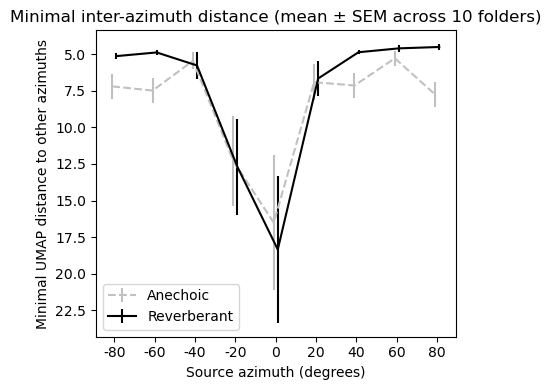

In [2]:
# ==== plot ====
x = np.arange(len(azimuths))

fig, ax = plt.subplots(figsize=(4.5, 4))

ax.errorbar(
    x - 0.05, mean_ane, yerr=sem_ane, color='silver',
    fmt='--', capsize=0, label='Anechoic'
)
ax.errorbar(
    x + 0.05, mean_rev, yerr=sem_rev, color='black',
    fmt='-', capsize=0, label='Reverberant'
)

ax.set_xticks(x)
ax.set_xticklabels(azimuths)
ax.set_xlabel("Source azimuth (degrees)")
ax.set_ylabel("Minimal UMAP distance to other azimuths")
ax.set_title("Minimal inter-azimuth distance (mean ± SEM across 10 folders)")
ax.legend()
# ax.grid(alpha=0.3)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('reverb_IHC3000_A01-10_n_neighbors'+str(n_neighbors)+'_min_dist'+str(min_dist)+\
            '_legend_off.pdf', dpi=300, bbox_inches='tight') # _legend_off
plt.show()

In [3]:
np.round(all_min_reverb)

array([[ 5.,  6.,  5., 18., 18.,  5.,  5.,  4.,  4.],
       [ 6.,  5.,  5., 13., 16.,  6.,  5.,  4.,  4.],
       [ 5.,  5.,  6., 11.,  6.,  5.,  5.,  6.,  5.],
       [ 5.,  5.,  5.,  5., 26.,  5.,  5.,  5.,  5.],
       [ 6.,  5.,  5., 33., 56.,  7.,  5.,  5.,  5.],
       [ 6.,  5.,  5.,  5., 27.,  5.,  4.,  5.,  4.],
       [ 4.,  4.,  4.,  5.,  5.,  6.,  5.,  4.,  4.],
       [ 5.,  5.,  5.,  5.,  7.,  7.,  5.,  4.,  4.],
       [ 5.,  5., 14., 28., 18., 17.,  5.,  5.,  5.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,  3.]], dtype=float32)